# **Simulasi LKS Provinsi Jawa Timur 2024** | 3 Januari 2026
---
Vionetta :b

# ***I. Data Understanding***

## **A. Penjabaran Studi Kasus**

Digital Civility Index (DCI) yang dilakukan oleh Microsoft merupakan alat yang digunakan untuk mengukur tingkat kecermatan dan perilaku sosial dalam dunia digital. Indonesia berada di urutan terbawah se-Asia Pasifik dengan poin 76.

Menurut survei, salah satu faktor yang mempengaruhi penurunan kesopanan social media user adalah ujaran kebencian atau hate speech. Hate speech dibedakan dari beberapa aspek seperti ras, agama, suku, warna kulit, etnis, dan sebagainya.

Sebagai developer, kami diutus untuk mengimplementasikan Natural Language Processing (NLP) untuk mendeteksi jenis hate speech dari dataset yang diambil dari platform Twitter, dengan jumlah 2000 tweet, periode pengambilan data mulai 20 Juli 2021 samoau 22 September 2021.

## **B. Import Library**

In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tkinter as tk

## **C. Import Dataset**

In [63]:
dataset = pd.read_csv("TABEL DATA LATIH HATESPEECH RISET.csv", sep=";", header=None)
dataset

,0,1,2
0,dxndelin,@amyliarm lingkunganmu keknya punya pemahaman ...,Netral
1,__succiduous,Udah jelek brengsek pula,Ras
2,KemenagMempawah,Lucunya penghuni negeri ini selalu di hiasi da...,Agama
3,1stKOREANguy1,"Yang jelek + miskin udah pasti bukan Kristen ,...",Ras
4,newsutdofficial,@MurtadhaOne1 Mereka memanfaatkan kebodohan ka...,Agama
...,...,...,...
2123,NaN,NaN,NaN
2124,NaN,NaN,NaN
2125,NaN,NaN,NaN
2126,NaN,NaN,NaN


# ***II. Data Preparation***

## **A. Exploratory Data Analysis** | Modul A

### 1. Buat Nama Kolom

In [64]:
dataset.columns = ["usn", "text", "class"]
dataset

,usn,text,class
0,dxndelin,@amyliarm lingkunganmu keknya punya pemahaman ...,Netral
1,__succiduous,Udah jelek brengsek pula,Ras
2,KemenagMempawah,Lucunya penghuni negeri ini selalu di hiasi da...,Agama
3,1stKOREANguy1,"Yang jelek + miskin udah pasti bukan Kristen ,...",Ras
4,newsutdofficial,@MurtadhaOne1 Mereka memanfaatkan kebodohan ka...,Agama
...,...,...,...
2123,NaN,NaN,NaN
2124,NaN,NaN,NaN
2125,NaN,NaN,NaN
2126,NaN,NaN,NaN


### 2. Inspeksi Informasi Ringkas

In [65]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2128 entries, 0 to 2127
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   usn     2001 non-null   object
 1   text    2001 non-null   object
 2   class   2000 non-null   object
dtypes: object(3)
memory usage: 50.0+ KB


### 3. Inspeksi Statistik Deskriptif

In [66]:
dataset.describe()

,usn,text,class
count,2001,2001,2000
unique,1717,1939,3
top,DodiAsyikin,IKN Potret Kemajuan,Netral
freq,7,7,836


### 4. Inspeksi Data NaN

In [67]:
dataset.isna().sum()

usn      127
text     127
class    128
dtype: int64

### 5. Inspeksi Data Duplicated

In [68]:
dataset.duplicated().sum()

169

### 6. Inspeksi Distribusi Kelas Target

In [69]:
target_count = dataset['class'].value_counts()
target_count

class
Netral    836
Ras       601
Agama     563
Name: count, dtype: int64

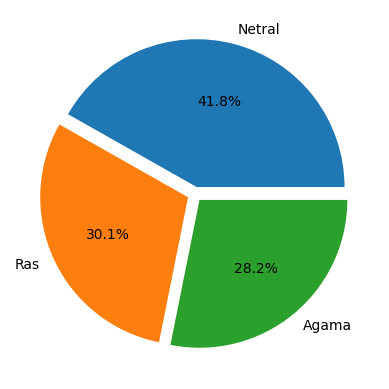

In [70]:
def unit(target_count):
    explode = [0.05] * len(target_count)
    plt.pie(target_count, labels=target_count.index, explode=explode, autopct="%1.1f%%")
    plt.show()

unit(target_count)

## **B. Text Preprocessing**

### 1. Hapus Data Kotor

In [71]:
dataset = dataset.dropna()
dataset = dataset.drop_duplicates()

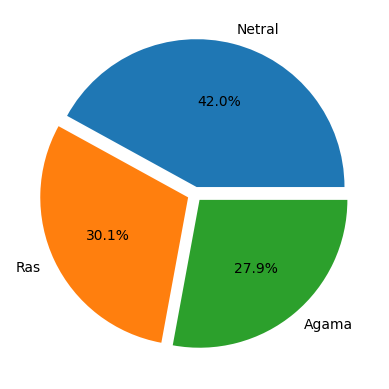

In [72]:
target_new = dataset['class'].value_counts()
target_new
unit(target_new)

Berdasarkan output di atas, didapati bahwa proses penghapusan data kotor memberi dampak tidak signifikan terhadap distribusi kelas target, sehingga ini berarti proses tersebut aman untuk dilakukan.

### 2. Encoding Target

In [73]:
# map_target = {'Netral': 0, 'Ras': 1, 'Agama': 2}
# reverse = {0: 'Netral', 1: 'Ras', 2: 'Agama'}

# dataset['class'] = dataset['class'].map(map_target)
# dataset = dataset.dropna(subset=['class'])
# dataset['class'] = dataset['class'].astype(int)
# dataset

### 3. Text Cleaning

Text cleaning ini membersihkan text dari formatnya ketika diambil dari social media, mencakup normalisasi text jadi lowercase semua, serta menghapus beberapa hal berikut:
1. Tag HTML
2. Mentions
3. Hastags
4. URL
5. Emoji
6. Angka
7. Tanda baca
8. Karakter spesial
9. Spasi berlebih

In [74]:
def text_cleaning(text: str) -> str:
    text = text.lower()

    punct_edges = ".,!?;:\"'()[]{}<>`~|\\/"
    tokens = text.split()
    kept = []

    for tok in tokens:
        core = tok.strip(punct_edges)

        if not core:
            continue

        if core.startswith("@"):
            u = core[1:]
            if u and all(c.isalnum() or c == "_" for c in u):
                continue

        if core.startswith("#"):
            h = core[1:]
            if h and all(c.isalnum() or c == "_" for c in h):
                continue

        if core.startswith(("http://", "https://", "www.")):
            continue

        kept.append(tok)

    text = " ".join(kept)
    text = "".join(c for c in text if ord(c) < 128)
    text = "".join(c for c in text if not c.isdigit())
    text = "".join(
        c for c in text
        if c.isalnum() or c == "_" or c.isspace()
    )
    text = " ".join(text.split())

    return text

dataset["text"] = dataset["text"].apply(text_cleaning)
dataset

,usn,text,class
0,dxndelin,lingkunganmu keknya punya pemahaman kl anak pu...,Netral
1,__succiduous,udah jelek brengsek pula,Ras
2,KemenagMempawah,lucunya penghuni negeri ini selalu di hiasi da...,Agama
3,1stKOREANguy1,yang jelek miskin udah pasti bukan kristen tap...,Ras
4,newsutdofficial,mereka memanfaatkan kebodohan kadrun melalui b...,Agama
...,...,...,...
1999,KakekGanteng6,ikn potret kemajuan,Netral
2000,Gungun88,kurang ajar memang orang cina itu sudah hidup ...,Ras
2001,Bita44,nah ini paham wahabi semakin merebak di sekita...,Agama
2002,Angga21,kita hidup di negara pancasila harus mengpleme...,Netral


### 4. Tokenization

Tokenisasi proses untuk memisahkan kata per kata agar tidak berupa string langsung. Tokenisasi ini dilakukan terlebih dahulu karena proses berikutnya seperti spelling correction, stemming, menghapus stopwords, yang which is proses menghapus sebuah kata, itu bisa bekerja lebih baik ketika sudah ditokenisasi dikarenakan kata sudah dipisah per kata sehingga lebih jelas.

In [75]:
dataset['text'] = dataset['text'].apply(lambda x: x.split())
dataset

,usn,text,class
0,dxndelin,"[lingkunganmu, keknya, punya, pemahaman, kl, a...",Netral
1,__succiduous,"[udah, jelek, brengsek, pula]",Ras
2,KemenagMempawah,"[lucunya, penghuni, negeri, ini, selalu, di, h...",Agama
3,1stKOREANguy1,"[yang, jelek, miskin, udah, pasti, bukan, kris...",Ras
4,newsutdofficial,"[mereka, memanfaatkan, kebodohan, kadrun, mela...",Agama
...,...,...,...
1999,KakekGanteng6,"[ikn, potret, kemajuan]",Netral
2000,Gungun88,"[kurang, ajar, memang, orang, cina, itu, sudah...",Ras
2001,Bita44,"[nah, ini, paham, wahabi, semakin, merebak, di...",Agama
2002,Angga21,"[kita, hidup, di, negara, pancasila, harus, me...",Netral


### 5. Spelling Correction

Kami melakukan spelling dengan kamus buatan. Kamus buatan ini dibuat dari daftar kata-kata yang frekuensinya 2 atau lebih, bisa ditentukan nilainya. Contoh:
1. ["aku": 5, "akuu": 1, "suka": 3, "sukaa": 1]
2. Yang masuk dikamus adalah ["aku", "suka"]

Tujuan dari kamus buatan ini adalah untuk mengurangi setidaknya kata-kata yang typo agar tidak banyak kata yang perlu dilakukan spelling manual.

Lalu dari kamus buatan ini, diukur dengan kata-kata yang typo atau nampak mirip dengan kata yang ada di kamus. Caranya adalah dengan mengukur perbedaan kata dan berapa langkah perubahan yang perlu dilakukan dari kata a (yang ada di kamus) dengan kata b (yang terdeteksi typo). Contoh:
1. edit_distance("aku", "aku") = 0 → sama persis
2. edit_distance("akuu", "aku") = 1 → hapus 1 huruf u
3. edit_distance("sukaa", "suka") = 1 → hapus 1 huruf a
4. edit_distance("mantap", "mantul") → butuh beberapa perubahan huruf

Ketika kata dibandingkan dengan kamus yang berisi kata yang dianggap benar, dan ternyata tidak ada yang sesuai, maka ia akan menghitung perbedaan tadi dengan semua kata yang ada di kamus, lalu yang diaplikasikan spelling yang benar untuk kata tersebut adalah yang perbedaannya paling sedikit.

In [76]:
def build_word_freq(text_series):
    freq = {}
    for doc in text_series:
        for w in doc:
            freq[w] = freq.get(w, 0) + 1
    return freq

word_freq = build_word_freq(dataset["text"])

MIN_COUNT = 2
vocab = {w for w, c in word_freq.items() if c >= MIN_COUNT}

def edit_distance(a, b):
    # pakai int biar jelas
    dp = np.zeros((len(a) + 1, len(b) + 1), dtype=int)
    dp[:, 0] = np.arange(len(a) + 1)
    dp[0, :] = np.arange(len(b) + 1)

    for i in range(1, len(a) + 1):
        for j in range(1, len(b) + 1):
            cost = 0 if a[i - 1] == b[j - 1] else 1
            dp[i, j] = min(
                dp[i - 1, j] + 1,
                dp[i, j - 1] + 1,
                dp[i - 1, j - 1] + cost
            )
    return dp[-1, -1]

def correct_word(word, vocab, word_freq, max_dist=2):
    if word in vocab:
        return word

    best = word
    best_dist = max_dist + 1
    best_freq = -1

    for v in vocab:
        if abs(len(v) - len(word)) > max_dist:
            continue
        d = edit_distance(word, v)
        if d <= max_dist:
            f = word_freq.get(v, 0)
            # pilih jarak paling kecil, kalau sama pilih yang lebih sering
            if (d < best_dist) or (d == best_dist and f > best_freq):
                best = v
                best_dist = d
                best_freq = f

    return best

def spelling_correction(tokens, vocab, word_freq, max_dist=2):
    return [correct_word(w, vocab, word_freq, max_dist=max_dist) for w in tokens]

dataset["text"] = dataset["text"].apply(lambda x: spelling_correction(x, vocab, word_freq, max_dist=2))
dataset

,usn,text,class
0,dxndelin,"[lingkungan, keknya, punya, pemahaman, kl, ana...",Netral
1,__succiduous,"[udah, jelek, brengsek, pula]",Ras
2,KemenagMempawah,"[lucunya, penghuni, negeri, ini, selalu, di, h...",Agama
3,1stKOREANguy1,"[yang, jelek, miskin, udah, pasti, bukan, kris...",Ras
4,newsutdofficial,"[mereka, memanfaatkan, kebodohan, kadrun, mela...",Agama
...,...,...,...
1999,KakekGanteng6,"[ikn, potret, kemajuan]",Netral
2000,Gungun88,"[kurang, ajar, memang, orang, cina, itu, sudah...",Ras
2001,Bita44,"[nah, ini, paham, wahabi, semakin, mereka, di,...",Agama
2002,Angga21,"[kita, hidup, di, negara, pancasila, harus, me...",Netral


Kami juga melakukan spelling correction manual untuk beberapa kata yang rumit dan perlu dibenarkan sendiri.

In [77]:
kamus_slang = {
    'yg': 'yang', 'gk': 'tidak', 'ga': 'tidak', 'tdk': 'tidak',
    'bgt': 'banget', 'dr': 'dari', 'dlm': 'dalam', 'utk': 'untuk',
    'gw': 'saya', 'gue': 'saya', 'lu': 'kamu', 'lo': 'kamu',
    'org': 'orang', 'dg': 'dengan', 'dgn': 'dengan', 'klo': 'kalau',
    'krn': 'karena', 'jg': 'juga', 'sdh': 'sudah', 'udh': 'sudah',
    'blm': 'belum', 'tp': 'tapi', 'sm': 'sama', 'bs': 'bisa',
    'aj': 'saja', 'aja': 'saja', 'bkn': 'bukan', 'hrs': 'harus', 'si': 'sih',
    'kek': 'seperti', 'tu': 'itu', 'ni': 'ini', 'tak': 'tidak', 'dah': 'sudah',
    'makin': 'semakin', "gak": "tidak", "kalo": "kalau", "kaya": "seperti", "udah": "sudah",
    "keknya": "sepertinya", "emang": "memang", "makin": "semakin", "kau": "kamu"
}

def normalize(tokens):
    if tokens is None or (isinstance(tokens, float) and pd.isna(tokens)):
        return tokens
    return [kamus_slang.get(w,w) for w in tokens]

dataset['text'] = dataset['text'].apply(normalize)
dataset

,usn,text,class
0,dxndelin,"[lingkungan, sepertinya, punya, pemahaman, kl,...",Netral
1,__succiduous,"[sudah, jelek, brengsek, pula]",Ras
2,KemenagMempawah,"[lucunya, penghuni, negeri, ini, selalu, di, h...",Agama
3,1stKOREANguy1,"[yang, jelek, miskin, sudah, pasti, bukan, kri...",Ras
4,newsutdofficial,"[mereka, memanfaatkan, kebodohan, kadrun, mela...",Agama
...,...,...,...
1999,KakekGanteng6,"[ikn, potret, kemajuan]",Netral
2000,Gungun88,"[kurang, ajar, memang, orang, cina, itu, sudah...",Ras
2001,Bita44,"[nah, ini, paham, wahabi, semakin, mereka, di,...",Agama
2002,Angga21,"[kita, hidup, di, negara, pancasila, harus, me...",Netral


### 6. Remove Stopwords

Stopwords adalah kata‑kata yang sangat sering muncul tapi biasanya tidak terlalu penting untuk memahami isi kalimat, seperti: yang, dan, di, ke, dari, untuk, adalah, dengan, para, itu, ini, nya, pun, dll.

Saat proses pembobotan kata nanti, kita tidak ingin kata-kata seperti ini masuk sebagai patokan utama memprediksi suatu kelas target hanya karena frekuensi munculnya yang banyak. Maka dari itu, stopwords ini harus dihapus.

In [78]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
stopwords = set(StopWordRemoverFactory().get_stop_words())

def remove(tokens):
    if tokens is None or (isinstance(tokens, float) and pd.isna(tokens)):
        return tokens
    return [w for w in tokens if w not in stopwords]

dataset['text'] = dataset['text'].apply(remove)
dataset

,usn,text,class
0,dxndelin,"[lingkungan, sepertinya, punya, pemahaman, kl,...",Netral
1,__succiduous,"[jelek, brengsek]",Ras
2,KemenagMempawah,"[lucunya, penghuni, negeri, selalu, hari, diwa...",Agama
3,1stKOREANguy1,"[jelek, miskin, bukan, kristen, cantikpinterja...",Ras
4,newsutdofficial,"[memanfaatkan, kebodohan, kadrun, melalui, ber...",Agama
...,...,...,...
1999,KakekGanteng6,"[ikn, potret, kemajuan]",Netral
2000,Gungun88,"[kurang, ajar, memang, orang, cina, hidup, gam...",Ras
2001,Bita44,"[nah, paham, wahabi, semakin, memakai, agama, ...",Agama
2002,Angga21,"[hidup, negara, pancasila, mengplementasikan, ...",Netral


hapus manual kata-kata yang tidak informatif

In [ ]:
manual_stopwords = {
    "sih", "kamu", "kok", "kau", "makin", "kalau", "kan", "kst", "dob", "nya", "lah",
    "buat", "pas", "jadi", "apa", "sama", "beda", "bukan", "mau", "banyak", "kstp", "aku",
    "iya", "tau", "pak", "dulu", "gua", "semua", "mana", "memang", "tuh"
}

def remove_manual(tokens):
    if tokens is None or (isinstance(tokens, float) and pd.isna(tokens)):
        return tokens
    return [w for w in tokens if w not in manual_stopwords]

dataset['text'] = dataset['text'].apply(remove_manual)
dataset

,usn,text,class
0,dxndelin,"[lingkungan, sepertinya, punya, pemahaman, kl,...",Netral
1,__succiduous,"[jelek, brengsek]",Ras
2,KemenagMempawah,"[lucunya, penghuni, negeri, selalu, hari, diwa...",Agama
3,1stKOREANguy1,"[jelek, miskin, kristen, cantikpinterjago, nuy...",Ras
4,newsutdofficial,"[memanfaatkan, kebodohan, kadrun, melalui, ber...",Agama
...,...,...,...
1999,KakekGanteng6,"[ikn, potret, kemajuan]",Netral
2000,Gungun88,"[kurang, ajar, memang, orang, cina, hidup, gam...",Ras
2001,Bita44,"[nah, paham, wahabi, semakin, memakai, agama, ...",Agama
2002,Angga21,"[hidup, negara, pancasila, mengplementasikan, ...",Netral


### 7. Stemming dan Lemmatization

Stemming adalah proses membuang imbuhan sesuai kbbi, contoh:
1. berlari : "lari"
2. memakan : "makan"
3. bermainan : bisa jadi "main" atau "permain"

Lemmatization adalah proses mengubah kata ke bentuk dasar yang benar secara kamus (lemma), dengan bantuan kamus kata, atau aturan tata bahasa (part-of-speech, dsb).
- Misalnya, "permainan" klo di stemming bisa jadi "permain" yang which is bukan kata baku, tapi di lemmatization kata ini jadi "main"

Di kasus ini, kami menggunakan stemming karena lebih sederhana, jauh lebih cepat, dan sudah cukup bagus untuk membantu menghasilkan prediksi model nanti, sedangkan lemmatization lebih berat dan tidak selalu bikin hasil jauh lebih baik.

In [80]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
stemmer = StemmerFactory().create_stemmer()

def stem(tokens):
    if tokens is None or (isinstance(tokens, float) and pd.isna(tokens)):
        return tokens
    return [stemmer.stem(w) for w in tokens]

dataset['text'] = dataset['text'].apply(stem)
dataset

,usn,text,class
0,dxndelin,"[lingkung, seperti, punya, paham, kl, anak, tu...",Netral
1,__succiduous,"[jelek, brengsek]",Ras
2,KemenagMempawah,"[lucu, huni, negeri, selalu, hari, warna, poli...",Agama
3,1stKOREANguy1,"[jelek, miskin, kristen, cantikpinterjago, nuy...",Ras
4,newsutdofficial,"[manfaat, bodoh, kadrun, lalu, berita, hoax]",Agama
...,...,...,...
1999,KakekGanteng6,"[ikn, potret, maju]",Netral
2000,Gungun88,"[kurang, ajar, memang, orang, cina, hidup, gam...",Ras
2001,Bita44,"[nah, paham, wahabi, makin, pakai, agama, teks...",Agama
2002,Angga21,"[hidup, negara, pancasila, mengplementasikan, ...",Netral


## **C. Splitting Data**

Splitting data menggunakan stratified, splitting data dan deklarasi fitur target dilakukan terlebih dahulu sebelum proses pembobotan kata agar tidak terjadi leakage data test di proses pembobotan kata.

In [81]:
def stratified_split(data, target, train_size=0.8, seed=42):
    np.random.seed(seed)
    train, test = [], []

    for cls in data[target].unique():
        g = data[data[target] == cls].sample(frac=1, random_state=seed)
        s = int(len(g) * train_size)
        train.append(g[:s])
        test.append(g[s:])

    return pd.concat(train).reset_index(drop=True), pd.concat(test).reset_index(drop=True)

train, test = stratified_split(dataset, "class")

## **D. Deklarasi Fitur dan Target**

In [82]:
X_train_text = train["text"].tolist()
X_test_text = test["text"].tolist()
y_train = train["class"].tolist()
y_test = test["class"].tolist()

## **E. Pembobotan Kata** | Modul B

### 1. TF, IDF, dan TF-IDF

Data yang akan kita proses berupa kata atau `object` sedangkan mesin hanya dapat memahami angka, maka kita akan mengubah kata ini menjadi angka, namun dengan bobot tertentu. Untuk menentukan bobot yang dimiliki oleh kata-kata ini, maka digunakan teknik tertentu.

TF atau Term Frequency adalah seberapa sering kata tersebut muncul dalam data atau dokumen tersebut. Contoh:
- Artikel terdiri dari 100 kata, kata “bola” muncul 5 kali
- TF(“bola”) = 5/100 = 0,05.

Jadi, makin sering muncul dalam dokumen itu, makin besar TF‑nya.

IDF atau Inverse Document Frequency adalah seberapa jarang kata tersebut muncul dalam data atau dokumen tersebut. Contoh:
- Kalau hampir semua dokumen punya kata seperti “yang”, “dan”, “atau”, IDF‑nya kecil sehingga dianggap kurang informatif.
- Kalau hanya sedikit dokumen yang punya kata seperti “inflasi”, “neural”, IDF‑nya besar sehingga dianggap lebih unik dan penting, informatif.

Jadi IDF menurunkan bobot kata yang terlalu umum, dan menaikkan bobot kata yang jarang tapi spesifik.

Lalu, TF-IDF merupakan gabuang dari keduanya. Mengalikan TF dengan IDF untuk tiap kata di tiap dokumen. Artinya, sebuah kata akan punya bobot tinggi hanya jika:
- Sering muncul di dokumen tersebut (TF tinggi), dan tidak terlalu umum di dokumen lain (IDF tinggi).

Dengan begini, kata‑kata yang benar‑benar menggambarkan isi dokumen, atau bisa dikatakan kata kunci dokumen tersebut, akan punya bobot paling besar. Sedangkan untuk kata umum seperti “yang”, “di”, “dan” bobotnya jadi kecil, meskipun sering muncul.

In [83]:
class tfidf:
    def __init__(self, max_features=None):
        self.max_features = max_features
        self.vocab = {}        
        self.idf = None     
        self.feature_names = []  
        self.n_features = 0
        self.n_docs = 0

    def fit(self, docs):
        self.n_docs = len(docs)

        df = {}   
        tf_global = {} 

        for doc in docs:
            if not doc:
                continue

            unique_terms = set(doc)
            for term in unique_terms:
                df[term] = df.get(term, 0) + 1

            for term in doc:
                tf_global[term] = tf_global.get(term, 0) + 1

        if self.max_features is None:
            terms = list(tf_global.keys())
        else:
            terms = sorted(tf_global.keys(),
                           key=lambda t: tf_global[t],
                           reverse=True)[: self.max_features]

        self.vocab = {term: idx for idx, term in enumerate(terms)}
        self.feature_names = terms
        self.n_features = len(terms)

        N = self.n_docs
        idf_vals = np.zeros(self.n_features, dtype=np.float32)
        for term, idx in self.vocab.items():
            df_t = df.get(term, 0)
            idf_vals[idx] = np.log((N + 1) / (df_t + 1)) + 1.0

        self.idf = idf_vals
        return self

    def trans(self, docs):
        """
        docs: list of list token
        return: matrix TF-IDF (n_docs, n_features)
        """
        n_samples = len(docs)
        X = np.zeros((n_samples, self.n_features), dtype=np.float32)

        for i, doc in enumerate(docs):
            if not doc:
                continue
            doc_len = len(doc)

            for term in doc:
                j = self.vocab.get(term)
                if j is not None:
                    X[i, j] += 1.0

            if doc_len > 0:
                X[i] /= float(doc_len)

        X *= self.idf
        return X

    def fit_trans(self, docs):
        self.fit(docs)
        return self.trans(docs)

In [84]:
vectorizer = tfidf(max_features=200)

X_train_tfidf = vectorizer.fit_trans(X_train_text)
X_test_tfidf  = vectorizer.trans(X_test_text)

print("TF-IDF Shape - Train:", X_train_tfidf.shape)
print("TF-IDF Shape - Test :", X_test_tfidf.shape)

TF-IDF Shape - Train: (1564, 200)
TF-IDF Shape - Test : (393, 200)


### 2. Top Kata dengan Frekuensi Muncul Terbanyak

#### *a. Bar Plot per Kelas*

In [85]:
def plot_top_tfidf_per_class(X_tfidf, y, feature_names, top_k=30):
    X_tfidf = np.asarray(X_tfidf)
    feature_names = np.asarray(list(feature_names))
    y = np.asarray(y)

    n_samples, n_features = X_tfidf.shape
    assert n_features == len(feature_names), \
        f"n_features ({n_features}) != len(feature_names) ({len(feature_names)})"

    classes = np.unique(y)

    for c in classes:
        mask = (y == c)
        X_c = X_tfidf[mask]

        if X_c.size == 0:
            print(f"Tidak ada dokumen untuk kelas {c}, dilewati.")
            continue

        class_scores = np.asarray(X_c.sum(axis=0)).ravel() 

        if np.all(class_scores == 0):
            print(f"Semua skor TF-IDF = 0 untuk kelas {c}, dilewati.")
            continue

        k = min(top_k, n_features)
        top_idx = np.argsort(class_scores)[::-1][:k]

        top_words = feature_names[top_idx]
        top_values = class_scores[top_idx]

        df_top = pd.DataFrame({
            "word": top_words,
            "score": top_values
        })

        plt.figure(figsize=(10, 8))
        sns.barplot(data=df_top, x="score", y="word", palette="magma")
        plt.xlabel(f"Total TF-IDF Score (kelas {c})")
        plt.ylabel("Word")
        plt.title(f"Top {len(df_top)} kata dengan TF-IDF tertinggi — kelas {c}")
        plt.tight_layout()
        plt.show()

C:\Users\RyzQ\AppData\Local\Temp\ipykernel_7728\512341312.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top, x="score", y="word", palette="magma")


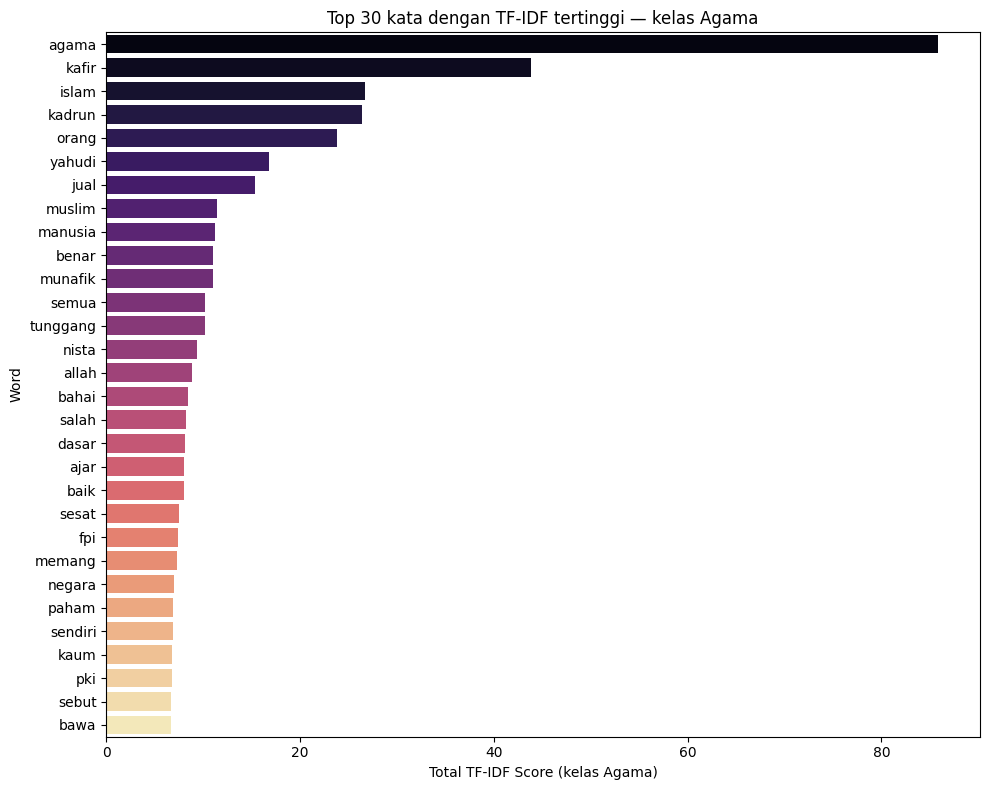

C:\Users\RyzQ\AppData\Local\Temp\ipykernel_7728\512341312.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top, x="score", y="word", palette="magma")


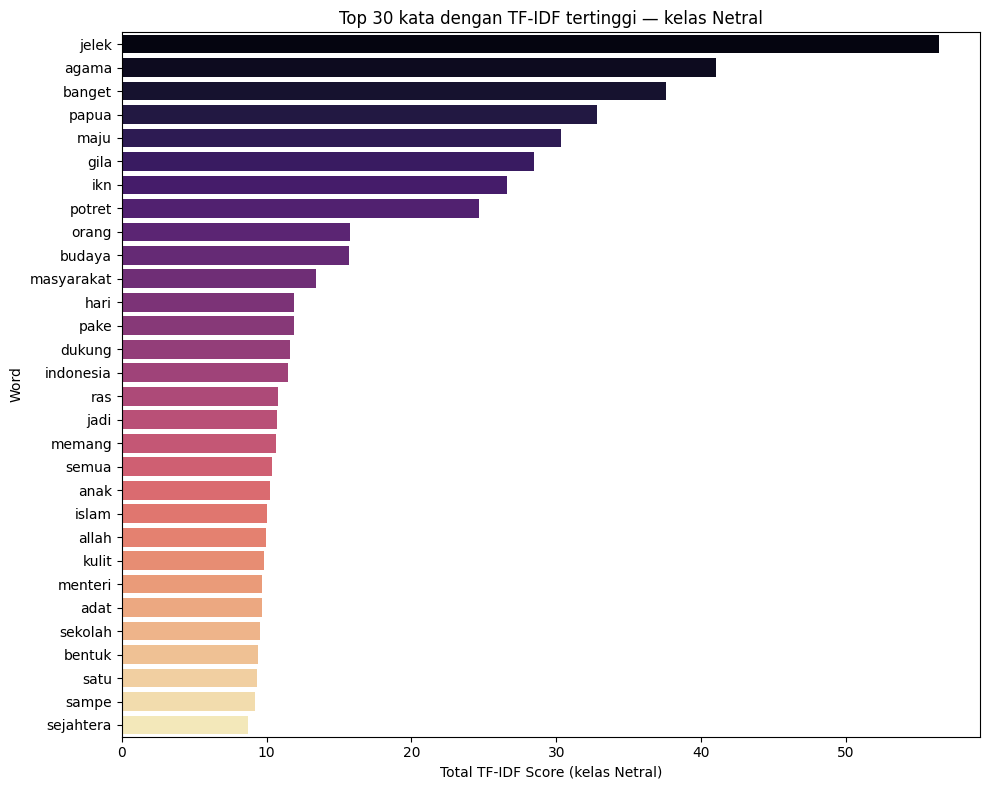

C:\Users\RyzQ\AppData\Local\Temp\ipykernel_7728\512341312.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top, x="score", y="word", palette="magma")


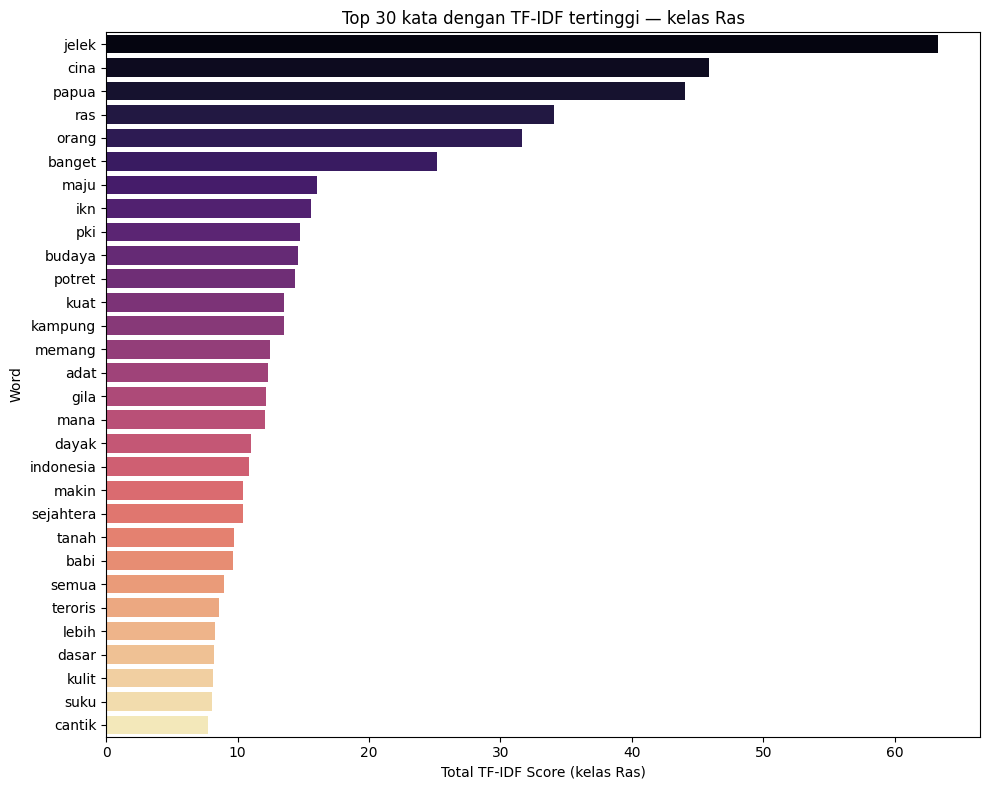

In [86]:
plot_top_tfidf_per_class(
    X_tfidf=X_train_tfidf,
    y=y_train,
    feature_names=vectorizer.feature_names,
    top_k=30
)

#### *b. Word Cloud Seluruh Data*

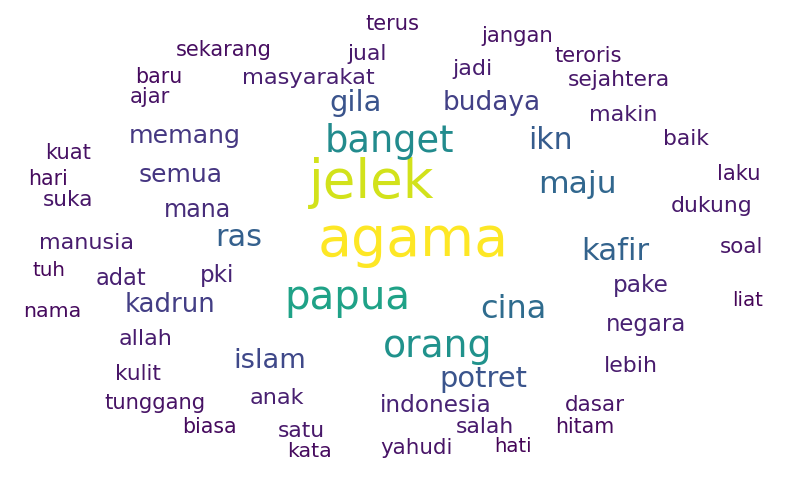

In [87]:
feature_names = np.array(vectorizer.feature_names)
global_scores = np.asarray(X_train_tfidf.sum(axis=0)).ravel()
n_top = min(100, len(feature_names))
top_idx = np.argsort(global_scores)[::-1][:n_top]

top_100 = pd.DataFrame({
    "word": feature_names[top_idx],
    "score": global_scores[top_idx]
})

if top_100.empty:
    print("Tidak ada kata untuk divisualisasikan")
else:
    words = top_100["word"].tolist()
    scores = top_100["score"].to_numpy(dtype=float)

    # skala ukuran font dari skor
    scores_min = scores.min()
    scores_max = scores.max()

    if scores_max == scores_min:
        sizes = np.full_like(scores, 20.0, dtype=float)
    else:
        score_range = scores_max - scores_min
        sizes = 14 + 26 * (scores - scores_min) / score_range  # 14–40 pt

    order = np.argsort(-sizes)
    words = [words[i] for i in order]
    sizes = sizes[order]
    n = len(words)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis("off")

    fig_w, fig_h = fig.get_size_inches()
    cw = 1.2 / (fig_w * 72)
    ch = 1.2 / (fig_h * 72)

    golden_angle = np.pi * (3 - np.sqrt(5))
    boxes = []

    def overlap(box, others):
        x0, x1, y0, y1 = box
        for ox0, ox1, oy0, oy1 in others:
            if x0 < ox1 and x1 > ox0 and y0 < oy1 and y1 > oy0:
                return True
        return False

    size_min = sizes.min()
    size_max = sizes.max()
    size_range = size_max - size_min if size_max != size_min else 1.0

    for i, (w, s) in enumerate(zip(words, sizes)):
        k = i
        placed = False

        while not placed and k < i + 300:
            r = 0.02 + 0.45 * min(1.0, np.sqrt(k / max(1, n)))
            theta = k * golden_angle

            x = 0.5 + r * np.cos(theta)
            y = 0.5 + r * np.sin(theta)

            width = cw * len(w) * s
            height = ch * s
            box = (x - width/2, x + width/2, y - height/2, y + height/2)

            if (box[0] < 0 or box[1] > 1 or
                box[2] < 0 or box[3] > 1 or
                overlap(box, boxes)):
                k += 1
                continue

            color_val = (s - size_min) / (size_range + 1e-9)
            color = plt.cm.viridis(color_val)

            ax.text(x, y, w, fontsize=float(s), color=color,
                    ha="center", va="center")
            boxes.append(box)
            placed = True

    plt.show()

## **F. Encoding Target**

In [88]:
map_target = {'Netral': 0, 'Ras': 1, 'Agama': 2}
reverse = {0: 'Netral', 1: 'Ras', 2: 'Agama'}

y_train = pd.Series(y_train).map(map_target).astype(int).to_numpy()
y_test  = pd.Series(y_test).map(map_target).astype(int).to_numpy()

# ***III. Modeling*** | Modul C

## **A. Model Application**

### 1. Multinomial Naive Bayes

Model Naive Bayes ini model yang belajar dari pola kemunculan fitur-fitur di tiap kelas, jadi menghitung seberapa besar kemungkinan atau probabilitas fitur-fitur tersebut untuk muncul di tiap kelas, lalu membuat prediksi klasifikasi dengan kelas yang peluangnya paling besar.

Disebut Naive karena model ini membuat asumsi sederhana, "kalo kita sudah tau kelasnya, maka setiap fitur dianggap tidak saling mempengaruhi. Padahal yang terjadi di dunia nyata itu kata‑kata tersebut jelas bisa saling terkait. Tapi model sengaja mengabaikan ketergantungan antar kata supaya perhitungan jadi sangat mudah, training jadi super cepat, dan anehnya, untuk banyak tugas NLP, hasilnya masih cukup bagus. Jadi “naive” itu bukan berarti algoritmanya bodoh, tapi asumsinya yang sangat sederhana.

Multinomial itu algoritma untuk data berbentuk hitungan (bobot kata, jumlah kata), dan nilai probabilitas fitur tidak boleh ada yang nol. Maka dari itu, ada metode Laplace Smoothing, jadi menggunakan nilai alpha supaya tidak ada fitur yang punya probabilitas nol hanya karena kebetulan tidak pernah muncul di kelas tertentu.

Model menghitung dua hal penting:
1. Prior kelas, yaitu seberapa sering setiap kelas muncul di data
2. Total kemunculan tiap fitur di tiap kelas

Jadi setelah fit, model jadi tau bahwa di kelas 0 itu fitur ke‑5 total muncul sekian kali, di kelas 1 sekian kali, dan seterusnya.

Semua hitungan fitur ini diubah menjadi peluang kemunculan fitur per kelas, lalu yang nilainya nol ditambah nilai alpha. Kemudian, untuk nilai prediksi, model mengambil bobot fiturnya, lalu dihitung untuk tiap kelas seberapa cocok data yang di-fit dengan pola kelas tersebut atau yang disebut log-likelihood. Lalu ditambah log prior kelas, sehingga kita dapat skor total untuk data tersebut atau yang disebut log_joint. Semakin besar skornya, maka semakin mungkin data tersebut berasal dari kelas tersebut.

Pada akhirnya, model punya patokan seberapa khas tiap fitur untuk tiap kelas, baik dalam bentuk angka biasa maupun log‑nya, yang nanti dipakai untuk memprediksi.

In [89]:
class MultinomialNB:
    def __init__(self, alpha=1.0):
        self.alpha = float(alpha)
        self.classes_ = None
        self.class_log_prior_ = None
        self.class_count_ = None
        self.feature_count_ = None
        self.feature_prob_ = None
        self.feature_log_prob_ = None
        self.n_features_ = None

    def _check_is_fitted(self):
        if self.feature_log_prob_ is None:
            raise ValueError("Model belum di-fit")

    def _ensure_inputs(self, X, y=None):
        X = np.asarray(X, dtype=np.float64)
        if y is not None:
            y = np.asarray(y).ravel()
        return X, y

    def _validate_features(self, X):
        if (X < 0).any():
            raise ValueError("Multinomial Naive Bayes memerlukan nilai fitur non-negatif")

    def fit(self, X, y):
        X, y = self._ensure_inputs(X, y)
        self._validate_features(X)
        
        self.classes_, y_enc = np.unique(y, return_inverse=True)
        n_samples, n_features = X.shape
        n_classes = self.classes_.size
        self.n_features_ = n_features
        
        self.class_count_ = np.bincount(y_enc, minlength=n_classes).astype(np.float64)
        self.class_log_prior_ = np.log(self.class_count_ / n_samples)

        Y_onehot = np.zeros((n_samples, n_classes), dtype=np.float64)
        Y_onehot[np.arange(n_samples), y_enc] = 1.0
        self.feature_count_ = Y_onehot.T @ X 

        smoothed_fc = self.feature_count_ + self.alpha
        smoothed_total = smoothed_fc.sum(axis=1, keepdims=True)
        
        self.feature_prob_ = smoothed_fc / smoothed_total
        self.feature_log_prob_ = np.log(self.feature_prob_)

        return self

    def predict_log_proba(self, X):
        self._check_is_fitted()
        X = np.asarray(X, dtype=np.float64)
        
        if X.shape[1] != self.n_features_:
            raise ValueError(
                f"Jumlah fitur tidak sesuai. Expected {self.n_features_}, "
                f"got {X.shape[1]}."
            )
            
        log_likelihood = X @ self.feature_log_prob_.T
        log_joint = log_likelihood + self.class_log_prior_
        
        return log_joint

    def predict_proba(self, X):
        log_joint = self.predict_log_proba(X)
        
        log_joint_stable = log_joint - log_joint.max(axis=1, keepdims=True)
        proba = np.exp(log_joint_stable)
        proba /= proba.sum(axis=1, keepdims=True)
        
        return proba

    def predict(self, X):
        log_joint = self.predict_log_proba(X)
        best_indices = np.argmax(log_joint, axis=1)
        return self.classes_[best_indices]

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == np.asarray(y).ravel())

    def plot_likelihood_heatmap(self, feature_names=None, cmap="rocket", annot=True, title="Feature Probabilities", figsize=None, top_k=None):
        self._check_is_fitted()
        
        if feature_names is None:
            feature_names = [f"F{i}" for i in range(self.n_features_)]
        
        prob_data = self.feature_prob_.copy()
        
        if top_k is not None and top_k < self.n_features_:
            feature_importance = prob_data.var(axis=0)
            top_indices = np.argsort(feature_importance)[-top_k:][::-1]
            prob_data = prob_data[:, top_indices]
            feature_names = [feature_names[i] for i in top_indices]

        data = pd.DataFrame(
            prob_data,
            index=[f"Class {cls}" for cls in self.classes_],
            columns=feature_names,
        )
        
        if figsize is None:
            n_feat_display = len(feature_names)
            figsize = (min(18, 3 + 0.7 * n_feat_display), 
                      max(4, 2 + 0.6 * len(self.classes_)))

        fig, ax = plt.subplots(figsize=figsize)
        sns.heatmap(
            data,
            annot=annot,
            fmt=".3f",
            cmap=cmap,
            cbar_kws={"label": "P(feature | class)"},
            ax=ax,
            linewidths=0.5,
        )
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel("Features", fontsize=10)
        ax.set_ylabel("Classes", fontsize=10)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        return fig, ax

    def plot_prior_posterior(self, X, sample_idx=0, figsize=(10, 5), title=None):
        self._check_is_fitted()
        X = np.asarray(X, dtype=np.float64)
        
        if X.shape[1] != self.n_features_:
            raise ValueError("Jumlah fitur tidak sesuai dengan model.")

        prior_probs = np.exp(self.class_log_prior_)
        posterior_probs = self.predict_proba(X[sample_idx:sample_idx+1])[0]

        x = np.arange(len(self.classes_))
        fig, ax = plt.subplots(figsize=figsize)
        width = 0.35
        
        bars1 = ax.bar(x - width/2, prior_probs, width, 
                       label='Prior P(class)', color='#4c72b0', alpha=0.85,
                       edgecolor='black', linewidth=0.5)
        bars2 = ax.bar(x + width/2, posterior_probs, width, 
                       label='Posterior P(class|X)', color='#dd8452', alpha=0.85,
                       edgecolor='black', linewidth=0.5)
        
        for bar in bars1:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(bar.get_x() + bar.get_width()/2, height),
                       xytext=(0, 3), textcoords="offset points",
                       ha='center', va='bottom', fontsize=8)
        for bar in bars2:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(bar.get_x() + bar.get_width()/2, height),
                       xytext=(0, 3), textcoords="offset points",
                       ha='center', va='bottom', fontsize=8)
        
        ax.set_xlabel("Class", fontsize=10)
        ax.set_ylabel("Probability", fontsize=10)
        ax.set_title(title or f"Prior vs Posterior — Sample #{sample_idx}", 
                    fontsize=12, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels([str(cls) for cls in self.classes_])
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3, axis='y', linestyle='--')
        ax.set_ylim(0, max(prior_probs.max(), posterior_probs.max()) * 1.2)
        plt.tight_layout()
        
        return fig, ax

    def plot_class_separation(self, X, y, figsize=(10, 6), 
                              title="Class Separation (Log-Likelihood)"):
        self._check_is_fitted()
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y).ravel()
        
        if X.shape[1] != self.n_features_:
            raise ValueError("Jumlah fitur tidak sesuai dengan model.")

        log_joint = self.predict_log_proba(X)
        
        fig, ax = plt.subplots(figsize=figsize)
        colors = plt.cm.tab10(np.linspace(0, 1, len(self.classes_)))

        for idx, cls in enumerate(self.classes_):
            mask = (y == cls)
            scores = log_joint[mask, idx]
            ax.hist(scores, bins=25, alpha=0.6, 
                   label=f"Class {cls} (n={mask.sum()})", 
                   color=colors[idx], edgecolor='black', linewidth=0.5)

        ax.set_xlabel("Log-Likelihood", fontsize=10)
        ax.set_ylabel("Frequency", fontsize=10)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.legend(loc='upper left')
        ax.grid(True, alpha=0.3, axis='y', linestyle='--')
        plt.tight_layout()
        
        return fig, ax

### 2. Best Params Cross Validation

In [90]:
def grid_search(X, y, alpha_range=None, cv_folds=5, shuffle=True, random_state=None, figsize=(14, 5), show_plots=True):
    X = np.asarray(X, dtype=np.float64)
    y = np.asarray(y).ravel()
    n_samples, n_features = X.shape
    
    if n_samples != len(y):
        raise ValueError(f"X ({n_samples}) dan y ({len(y)}) harus sama jumlahnya")
    
    if alpha_range is None:
        alpha_range = [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0]
    alpha_list = np.array(alpha_range, dtype=np.float64)
    n_alphas = len(alpha_list)
    
    indices = np.arange(n_samples)
    if shuffle:
        rng = np.random.default_rng(random_state)
        indices = rng.permutation(n_samples)
    
    X_shuffled = X[indices]
    y_shuffled = y[indices]
    
    fold_sizes = np.full(cv_folds, n_samples // cv_folds, dtype=int)
    fold_sizes[:n_samples % cv_folds] += 1
    fold_indices = np.cumsum(np.concatenate([[0], fold_sizes]))
    
    fold_val_masks = []
    for fold in range(cv_folds):
        val_mask = np.zeros(n_samples, dtype=bool)
        val_mask[fold_indices[fold]:fold_indices[fold + 1]] = True
        fold_val_masks.append(val_mask)
    
    print("=" * 70)
    print("GRID SEARCH CROSS-VALIDATION - MULTINOMIAL NAIVE BAYES")
    print("=" * 70)
    print(f"  Samples      : {n_samples}")
    print(f"  Features     : {n_features}")
    print(f"  Classes      : {len(np.unique(y))}")
    print(f"  CV Folds     : {cv_folds}")
    print(f"  Alpha Values : {n_alphas}")
    print("-" * 70)
    print(f"  {'Alpha':<10} | {'Mean Acc':>10} | {'Std':>8} | {'Mean Err':>10}")
    print("-" * 70)
    
    all_fold_accuracies = np.zeros((n_alphas, cv_folds))
    
    for ai, alpha in enumerate(alpha_list):
        for fold, val_mask in enumerate(fold_val_masks):
            X_train = X_shuffled[~val_mask]
            y_train = y_shuffled[~val_mask]
            X_val = X_shuffled[val_mask]
            y_val = y_shuffled[val_mask]
            
            model = MultinomialNB(alpha=alpha)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            
            all_fold_accuracies[ai, fold] = np.mean(y_val == y_pred)
    
    mean_accuracies = all_fold_accuracies.mean(axis=1)
    std_accuracies = all_fold_accuracies.std(axis=1)
    mean_errors = 1.0 - mean_accuracies
    
    best_idx = np.argmax(mean_accuracies)
    best_alpha = alpha_list[best_idx]
    best_accuracy = mean_accuracies[best_idx]
    best_std = std_accuracies[best_idx]
    
    for ai, alpha in enumerate(alpha_list):
        marker = " ← BEST" if ai == best_idx else ""
        print(f"  {alpha:<10.4f} | {mean_accuracies[ai]:>10.4f} | "
              f"{std_accuracies[ai]:>8.4f} | {mean_errors[ai]:>10.4f}{marker}")
    
    print("-" * 70)
    print("BEST PARAMETERS:")
    print(f"  Alpha        : {best_alpha}")
    print(f"  CV Accuracy  : {best_accuracy:.4f} ± {best_std:.4f}")
    print(f"  CV Error     : {1 - best_accuracy:.4f}")
    print("=" * 70)
    
    results = {
        'alpha_values': alpha_list,
        'fold_accuracies': all_fold_accuracies,
        'mean_accuracies': mean_accuracies,
        'std_accuracies': std_accuracies,
        'mean_errors': mean_errors,
        'cv_folds': cv_folds,
    }
    
    best_params = {
        'alpha': best_alpha,
        'accuracy': best_accuracy,
        'error': 1 - best_accuracy,
        'std': best_std,
    }
    
    if show_plots:
        grid_result(results, best_params, figsize)
    
    return results, best_params

def grid_result(
    results,
    best_params,
    figsize_line=(8, 4),
    figsize_heatmap=(8, 6),
    figsize_box=(10, 6),
):
    alpha_list         = np.array(results['alpha_values'])
    mean_accuracies    = np.array(results['mean_accuracies'])
    std_accuracies     = np.array(results['std_accuracies'])
    mean_errors        = np.array(results['mean_errors'])
    all_fold_accuracies = np.array(results['fold_accuracies'])  # shape: (n_alphas, cv_folds)
    cv_folds           = results['cv_folds']

    best_alpha   = best_params['alpha']
    best_accuracy = best_params['accuracy']
    best_idx     = np.argmax(mean_accuracies)
    n_alphas     = len(alpha_list)

    fig1, ax1 = plt.subplots(figsize=figsize_line)

    ax1.plot(alpha_list, mean_accuracies, 'o-', linewidth=2.5,
             markersize=8, color='#2ecc71', label='Mean Accuracy')
    ax1.fill_between(alpha_list,
                     mean_accuracies - std_accuracies,
                     mean_accuracies + std_accuracies,
                     alpha=0.25, color='#2ecc71', label='±1 Std')
    ax1.axvline(x=best_alpha, color='#e74c3c', linestyle='--',
                linewidth=2, label=f'Best α={best_alpha}')
    ax1.scatter([best_alpha], [best_accuracy], s=200, color='#e74c3c',
                zorder=5, edgecolor='white', linewidth=2)

    ax1.set_xscale('log')
    ax1.set_xlabel("Alpha (log scale)", fontsize=11)
    ax1.set_ylabel("Accuracy", fontsize=11)
    ax1.set_title("CV Accuracy vs Alpha", fontsize=13, fontweight='bold')
    ax1.legend(loc='best', fontsize=9)
    ax1.grid(True, alpha=0.3, linestyle='--')

    fig1.tight_layout()
    plt.show()

    fig2, ax2 = plt.subplots(figsize=figsize_line)

    ax2.plot(alpha_list, mean_errors, 's-', linewidth=2.5,
             markersize=8, color='#e74c3c', label='Mean Error')
    ax2.fill_between(alpha_list,
                     mean_errors - std_accuracies,
                     mean_errors + std_accuracies,
                     alpha=0.25, color='#e74c3c', label='±1 Std')
    ax2.axvline(x=best_alpha, color='#3498db', linestyle='--',
                linewidth=2, label=f'Best α={best_alpha}')

    ax2.set_xscale('log')
    ax2.set_xlabel("Alpha (log scale)", fontsize=11)
    ax2.set_ylabel("Error Rate", fontsize=11)
    ax2.set_title("CV Error vs Alpha", fontsize=13, fontweight='bold')
    ax2.legend(loc='best', fontsize=9)
    ax2.grid(True, alpha=0.3, linestyle='--')

    fig2.tight_layout()
    plt.show()
    
    fig3, ax3 = plt.subplots(figsize=figsize_heatmap)

    heatmap_df = pd.DataFrame(
        all_fold_accuracies,
        index=[f'α={a:.3g}' for a in alpha_list],
        columns=[f'Fold {i+1}' for i in range(cv_folds)]
    )

    sns.heatmap(heatmap_df, annot=True, fmt='.3f', cmap='RdYlGn',
                ax=ax3, cbar_kws={'label': 'Accuracy'},
                linewidths=0.5, vmin=0, vmax=1)

    ax3.set_title("Accuracy: Alpha × Fold", fontsize=13, fontweight='bold')

    ax3.add_patch(plt.Rectangle(
        (0, best_idx), cv_folds, 1,
        fill=False, edgecolor='blue', linewidth=3
    ))

    fig3.tight_layout()
    plt.show()
    
    fig4, ax4 = plt.subplots(
        figsize=(max(figsize_box[0], n_alphas * 0.8), figsize_box[1])
    )

    bp = ax4.boxplot(
        [all_fold_accuracies[i] for i in range(n_alphas)],
        positions=np.arange(n_alphas),
        widths=0.6,
        patch_artist=True,
        showmeans=True,
        meanprops=dict(marker='D', markerfacecolor='gold',
                       markeredgecolor='black', markersize=7)
    )

    colors = sns.color_palette("viridis", n_alphas)
    for i, (patch, color) in enumerate(zip(bp['boxes'], colors)):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
        if i == best_idx:
            patch.set_edgecolor('red')
            patch.set_linewidth(3)

    ax4.set_xticks(np.arange(n_alphas))
    ax4.set_xticklabels([f'{a:.3g}' for a in alpha_list], rotation=45)
    ax4.set_xlabel("Alpha", fontsize=11)
    ax4.set_ylabel("Accuracy", fontsize=11)
    ax4.set_title("Accuracy Distribution per Alpha",
                  fontsize=13, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y', linestyle='--')

    fig4.tight_layout()
    plt.show()

GRID SEARCH CROSS-VALIDATION - MULTINOMIAL NAIVE BAYES
  Samples      : 1564
  Features     : 200
  Classes      : 3
  CV Folds     : 5
  Alpha Values : 7
----------------------------------------------------------------------
  Alpha      |   Mean Acc |      Std |   Mean Err
----------------------------------------------------------------------
  0.1000     |     0.6132 |   0.0320 |     0.3868
  0.5000     |     0.6157 |   0.0301 |     0.3843
  1.0000     |     0.6196 |   0.0176 |     0.3804
  1.5000     |     0.6272 |   0.0126 |     0.3728
  2.0000     |     0.6247 |   0.0134 |     0.3753
  2.5000     |     0.6272 |   0.0134 |     0.3728
  3.0000     |     0.6285 |   0.0108 |     0.3715 ← BEST
----------------------------------------------------------------------
BEST PARAMETERS:
  Alpha        : 3.0
  CV Accuracy  : 0.6285 ± 0.0108
  CV Error     : 0.3715


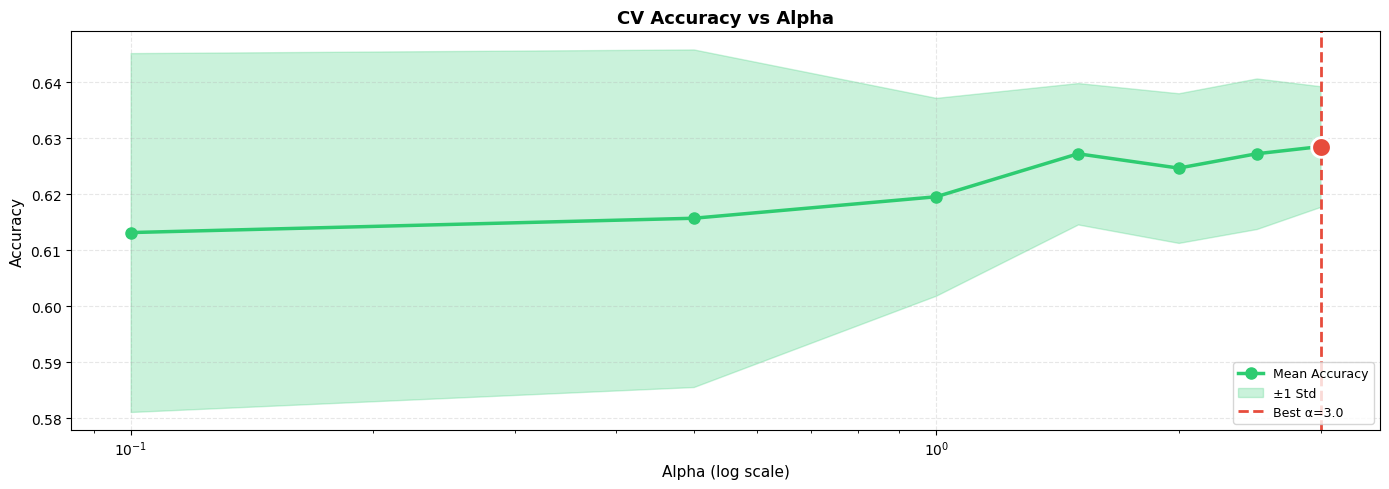

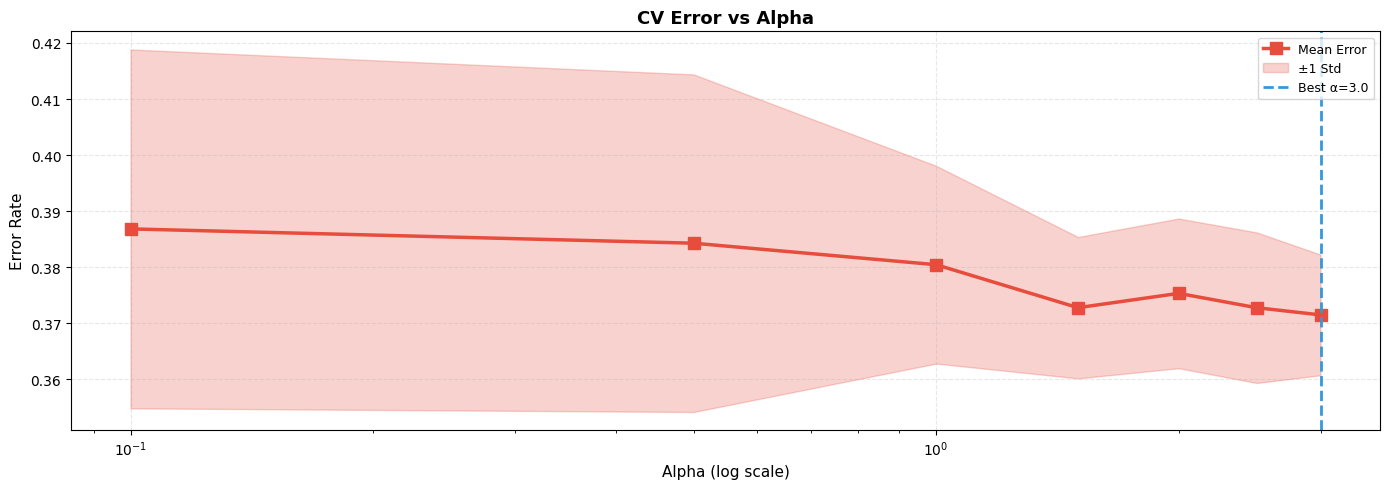

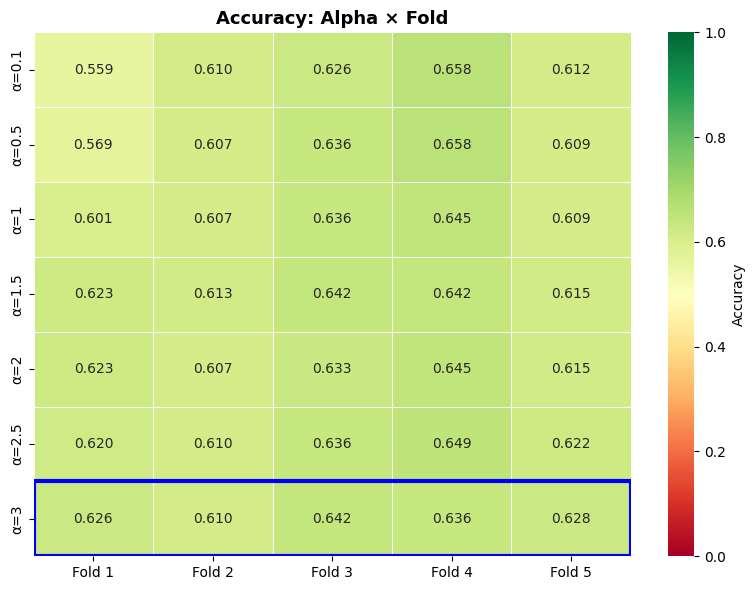

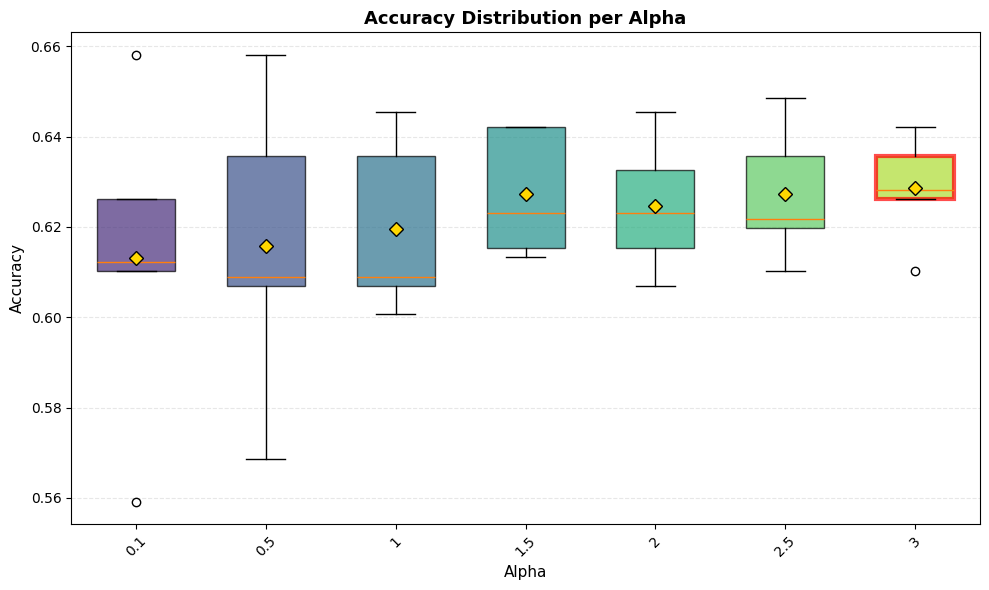

In [91]:
results, best = grid_search(X_train_tfidf, y_train, alpha_range=[0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0])

### 3. Built Model

In [92]:
model = MultinomialNB(alpha=2.0)
model.fit(X_train_tfidf, y_train)

y_pred_train = model.predict(X_train_tfidf)
y_pred_test = model.predict(X_test_tfidf)

y_proba_train = model.predict_proba(X_train_tfidf)
y_proba_test = model.predict_proba(X_test_tfidf)

## **B. Model Evaluation**

### 1. K-Fold Cross Validation

In [93]:
def nb_kfold(X, y, alpha=1.0, n_folds=5, shuffle=True, random_state=None, verbose=True, show_plot=True, figsize=(12, 5)):
    X = np.asarray(X, dtype=np.float64)
    y = np.asarray(y).ravel()
    n_samples, n_features = X.shape
    
    if n_samples != len(y):
        raise ValueError(f"X ({n_samples}) dan y ({len(y)}) harus sama jumlahnya")
    
    if n_folds < 2:
        raise ValueError(f"n_folds harus >= 2, got {n_folds}")
    
    if n_folds > n_samples:
        raise ValueError(f"n_folds ({n_folds}) tidak boleh > n_samples ({n_samples})")
    
    indices = np.arange(n_samples)
    if shuffle:
        rng = np.random.default_rng(random_state)
        indices = rng.permutation(n_samples)
    
    X_shuffled = X[indices]
    y_shuffled = y[indices]
    
    fold_sizes = np.full(n_folds, n_samples // n_folds, dtype=int)
    fold_sizes[:n_samples % n_folds] += 1
    fold_indices = np.cumsum(np.concatenate([[0], fold_sizes]))
    
    fold_accuracies = np.zeros(n_folds)
    fold_predictions = []
    fold_true_labels = []
    
    if verbose:
        print("=" * 65)
        print("K-FOLD CROSS VALIDATION - MULTINOMIAL NAIVE BAYES")
        print("=" * 65)
        print(f"  Samples      : {n_samples}")
        print(f"  Features     : {n_features}")
        print(f"  Classes      : {len(np.unique(y))}")
        print(f"  Folds        : {n_folds}")
        print(f"  Alpha        : {alpha}")
        print("-" * 65)
    
    for fold in range(n_folds):
        val_start = fold_indices[fold]
        val_end = fold_indices[fold + 1]
        
        val_mask = np.zeros(n_samples, dtype=bool)
        val_mask[val_start:val_end] = True
        
        X_train = X_shuffled[~val_mask]
        y_train = y_shuffled[~val_mask]
        X_val = X_shuffled[val_mask]
        y_val = y_shuffled[val_mask]
        
        model = MultinomialNB(alpha=alpha)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        
        accuracy = np.mean(y_val == y_pred)
        fold_accuracies[fold] = accuracy
        
        fold_predictions.append(y_pred)
        fold_true_labels.append(y_val)
        
        if verbose:
            print(f"  Fold {fold + 1}/{n_folds}: "
                  f"Train={len(y_train):4d}, Val={len(y_val):4d}, "
                  f"Acc={accuracy:.4f}")
    
    fold_errors = 1.0 - fold_accuracies
    mean_accuracy = fold_accuracies.mean()
    std_accuracy = fold_accuracies.std()
    mean_error = fold_errors.mean()
    std_error = fold_errors.std()
    
    if verbose:
        print("-" * 65)
        print(f"  MEAN ACCURACY : {mean_accuracy:.4f} ± {std_accuracy:.4f}")
        print(f"  MEAN ERROR    : {mean_error:.4f} ± {std_error:.4f}")
        print("=" * 65)
    
    results = {
        'fold_accuracies': fold_accuracies,
        'fold_errors': fold_errors,
        'mean_accuracy': mean_accuracy,
        'std_accuracy': std_accuracy,
        'mean_error': mean_error,
        'std_error': std_error,
        'alpha': alpha,
        'n_folds': n_folds,
        'predictions': fold_predictions,
        'true_labels': fold_true_labels,
    }
    
    if show_plot:
        _plot_kfold_results(results, figsize)
    
    return results

def _plot_kfold_results(results, figsize_bar=(8, 4), figsize_box=(6, 4)):
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    fold_accuracies = np.array(results['fold_accuracies'])
    n_folds = results['n_folds']
    mean_accuracy = results['mean_accuracy']
    std_accuracy = results['std_accuracy']
    alpha = results['alpha']

    fig1, ax1 = plt.subplots(figsize=figsize_bar)

    x = np.arange(1, n_folds + 1)
    colors = sns.color_palette("Blues_d", n_folds)

    bars = ax1.bar(x, fold_accuracies, color=colors,
                   edgecolor='black', linewidth=0.8)
    ax1.axhline(y=mean_accuracy, color='#e74c3c', linestyle='--',
                linewidth=2.5, label=f'Mean: {mean_accuracy:.4f}')
    ax1.fill_between([0.4, n_folds + 0.6],
                     mean_accuracy - std_accuracy,
                     mean_accuracy + std_accuracy,
                     alpha=0.15, color='#e74c3c',
                     label=f'±1 Std: {std_accuracy:.4f}')

    for bar, acc in zip(bars, fold_accuracies):
        ax1.annotate(f'{acc:.3f}',
                     xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                     xytext=(0, 5), textcoords="offset points",
                     ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax1.set_xlabel("Fold", fontsize=11)
    ax1.set_ylabel("Accuracy", fontsize=11)
    ax1.set_title(f"Accuracy per Fold (α={alpha})",
                  fontsize=13, fontweight='bold')
    ax1.set_xticks(x)
    ax1.legend(loc='lower right', fontsize=9)
    ax1.grid(True, alpha=0.3, axis='y', linestyle='--')
    ax1.set_ylim(0, min(1.15, fold_accuracies.max() * 1.2))

    fig1.tight_layout()
    plt.show()

K-FOLD CROSS VALIDATION - MULTINOMIAL NAIVE BAYES
  Samples      : 1564
  Features     : 200
  Classes      : 3
  Folds        : 5
  Alpha        : 2.0
-----------------------------------------------------------------
  Fold 1/5: Train=1251, Val= 313, Acc=0.6006
  Fold 2/5: Train=1251, Val= 313, Acc=0.6645
  Fold 3/5: Train=1251, Val= 313, Acc=0.6422
  Fold 4/5: Train=1251, Val= 313, Acc=0.5911
  Fold 5/5: Train=1252, Val= 312, Acc=0.6250
-----------------------------------------------------------------
  MEAN ACCURACY : 0.6247 ± 0.0268
  MEAN ERROR    : 0.3753 ± 0.0268


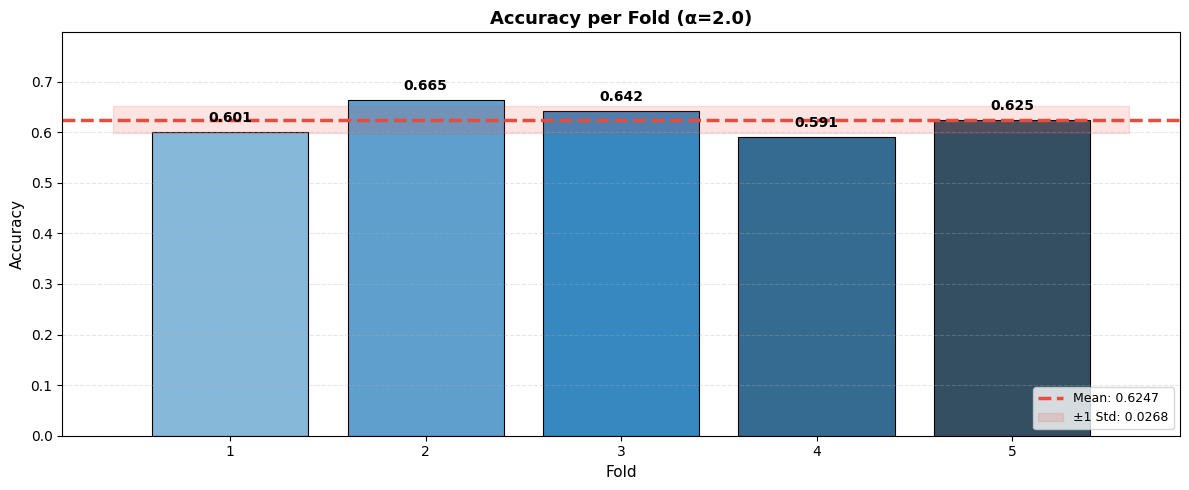

In [94]:
results = nb_kfold(X_train_tfidf, y_train, alpha=2.0, n_folds=5)

### 2. Evaluation Metrics

#### *a. Fungsi Evaluation*

In [95]:
def accuracy_score(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(y_true == y_pred)

def confusion_matrix(y_true, y_pred, labels=None):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)

    if labels is None:
        labels = np.unique(np.concatenate([y_true, y_pred]))
    
    cm = np.zeros((len(labels), len(labels)), dtype=int)
    idx = {lab: i for i, lab in enumerate(labels)}

    for t, p in zip(y_true, y_pred):
        cm[idx[t], idx[p]] += 1

    return cm, labels

def precision_recall_f1(y_true, y_pred, labels=None, average="micro"):
    cm, labels = confusion_matrix(y_true, y_pred, labels)

    tp = np.diag(cm).astype(float)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp

    with np.errstate(divide="ignore", invalid="ignore"):
        prec = np.where(tp+fp == 0, 0, tp/(tp+fp))
        rec = np.where(tp+fn == 0,0, tp/(tp+fn))
        f1 = np.where(prec+rec == 0,0,2*prec*rec/(prec+rec))

    if average == "macro":
        return prec.mean(), rec.mean(), f1.mean()

    if average == "micro":
        TP, FP, FN = tp.sum(), fp.sum(), fn.sum()
        p = TP/(TP+FP) if TP +FP > 0 else 0
        r = TP/(TP+FN) if TP+FN > 0 else 0 
        f = 2*p*r/(p+r) if p+r > 0 else 0 
        return p, r, f

    return prec, rec, f1, labels

def roc_auc_score_ovr(y_true, proba, labels=None, n_thresholds=200):
    y_true = np.asarray(y_true)
    proba = np.asarray(proba, float)

    if labels is None:
        labels = np.unique(y_true)

    aucs = []

    for k, lab in enumerate(labels):
        y_bin = (y_true == lab).astype(int)
        scores = proba[:, k]

        P = y_bin.sum()
        N = len(y_bin) - P
        tpr, fpr = [], []

        for t in np.linspace(0, 1, n_thresholds):
            pred = scores >= t
            TP = np.sum(pred & (y_bin == 1))
            FP = np.sum(pred & (y_bin == 0))
            tpr.append(TP/P if P else 0)
            fpr.append(FP/N if N else 0)

        order = np.argsort(fpr)
        aucs.append(np.trapz(np.array(tpr)[order], np.array(fpr)[order]))

    return float(np.mean(aucs))

#### *b. Training Model*

In [96]:
print("KNN | TRAINING | MICRO")
acc = accuracy_score(y_train, y_pred_train)
prec, rec, f1 = precision_recall_f1(y_train, y_pred_train, average="micro")

try:
    auc = roc_auc_score_ovr(y_train, y_proba_train)
    print(f"Acc={acc:.4f} | Prec={prec:.4f} | Rec={rec:.4f} | F1={f1:.4f} | AUC={auc:.4f}")
except Exception:
    print(f"Acc={acc:.4f} | Prec={prec:.4f} | Rec={rec:.4f} | F1={f1:.4f}")

KNN | TRAINING | MICRO
Acc=0.7174 | Prec=0.7174 | Rec=0.7174 | F1=0.7174 | AUC=0.8740


In [97]:
print("KNN | TRAINING | MACRO")
acc = accuracy_score(y_train, y_pred_train)
prec, rec, f1 = precision_recall_f1(y_train, y_pred_train, average="macro")

try:
    auc = roc_auc_score_ovr(y_train, y_proba_train)
    print(f"Acc={acc:.4f} | Prec={prec:.4f} | Rec={rec:.4f} | F1={f1:.4f} | AUC={auc:.4f}")
except Exception:
    print(f"Acc={acc:.4f} | Prec={prec:.4f} | Rec={rec:.4f} | F1={f1:.4f}")

KNN | TRAINING | MACRO
Acc=0.7174 | Prec=0.7490 | Rec=0.7012 | F1=0.7135 | AUC=0.8740


#### *c. Testing Model*

In [98]:
print("KNN | TESTING | MICRO")
acc = accuracy_score(y_test, y_pred_test)
prec, rec, f1 = precision_recall_f1(y_test, y_pred_test, average="micro")

try:
    auc = roc_auc_score_ovr(y_test, y_proba_test)
    print(f"Acc={acc:.4f} | Prec={prec:.4f} | Rec={rec:.4f} | F1={f1:.4f} | AUC={auc:.4f}")
except:
    print(f"Acc={acc:.4f} | Prec={prec:.4f} | Rec={rec:.4f} | F1={f1:.4f}")

KNN | TESTING | MICRO
Acc=0.6590 | Prec=0.6590 | Rec=0.6590 | F1=0.6590 | AUC=0.8122


In [99]:
print("KNN | TESTING | MACRO")
acc = accuracy_score(y_test, y_pred_test)
prec, rec, f1 = precision_recall_f1(y_test, y_pred_test, average="macro")

try:
    auc = roc_auc_score_ovr(y_test, y_proba_test)
    print(f"Acc={acc:.4f} | Prec={prec:.4f} | Rec={rec:.4f} | F1={f1:.4f} | AUC={auc:.4f}")
except:
    print(f"Acc={acc:.4f} | Prec={prec:.4f} | Rec={rec:.4f} | F1={f1:.4f}")

KNN | TESTING | MACRO
Acc=0.6590 | Prec=0.7004 | Rec=0.6434 | F1=0.6552 | AUC=0.8122


### 3. Confusion Matrix

#### *a. Fungsi Confusion Matrix*

In [100]:
def plot_confusion_heatmap(cm, labels, title="Confusion Matrix", figsize=(5, 4)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=labels, yticklabels=labels, linewidths=0.5, linecolor="white")
    ax.set(xlabel="Predicted", ylabel="True", title=title)
    plt.tight_layout()
    return fig, ax

def print_class(cm, labels):
    print("Detail Prediksi Per Kelas")
    print("-"*25)

    for i, lab in enumerate(labels):
        total = cm[i].sum()
        benar = cm[i, i]
        salah = total - benar

        print(f"\nKelas {lab}")
        print(f"Total: {total}")
        print(f"Benar: {benar}")
        print(f"Salah: {salah}")

        if salah > 0:
            print("Rincian:")
            for j, lab_lain in enumerate(labels):
                if i != j and cm[i, j] >0:
                    print(f"> ke kelas {lab_lain}: {cm[i, j]}")

#### *b. Training Model*

Detail Prediksi Per Kelas
-------------------------

Kelas 0
Total: 657
Benar: 550
Salah: 107
Rincian:
> ke kelas 1: 55
> ke kelas 2: 52

Kelas 1
Total: 471
Benar: 266
Salah: 205
Rincian:
> ke kelas 0: 183
> ke kelas 2: 22

Kelas 2
Total: 436
Benar: 306
Salah: 130
Rincian:
> ke kelas 0: 116
> ke kelas 1: 14


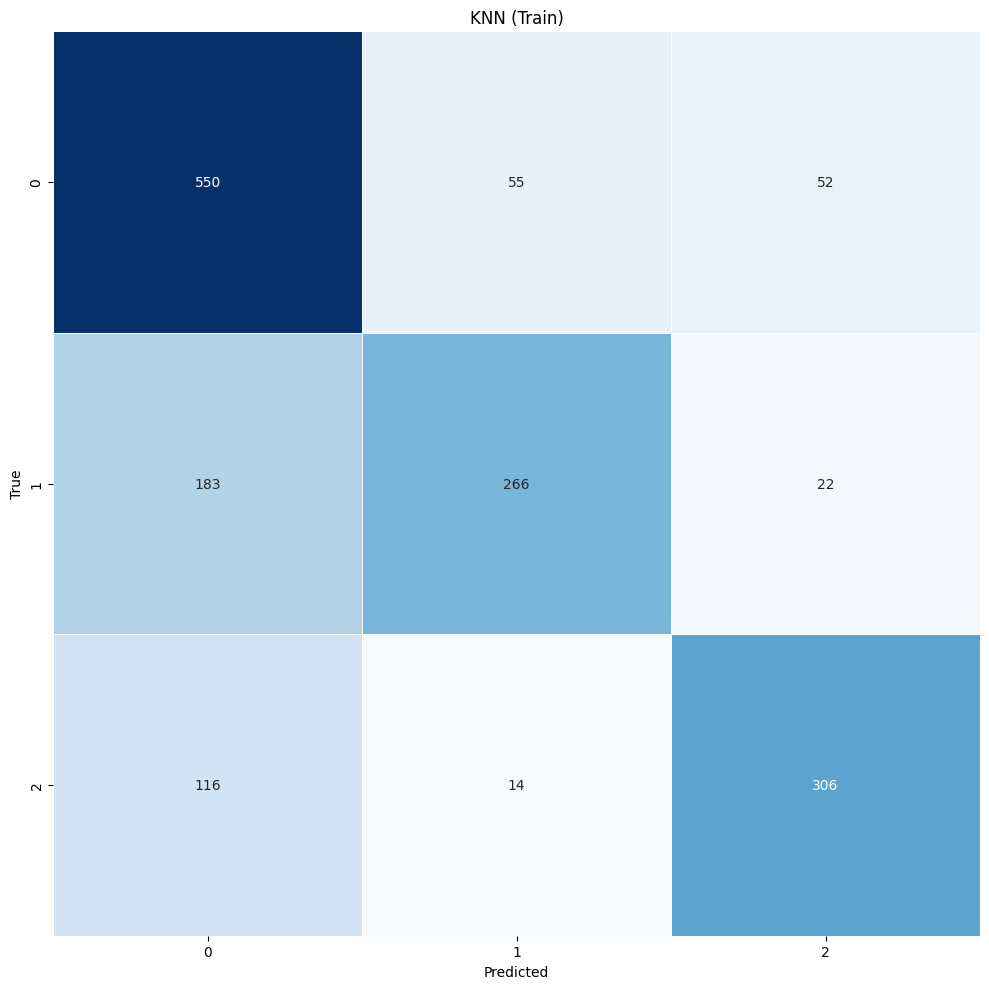

In [101]:
cm, labels = confusion_matrix(y_train, y_pred_train)
print_class(cm, labels)
plot_confusion_heatmap(cm, labels, "KNN (Train)", figsize=(10,10))
plt.show()

#### *c. Testing Model*

Detail Prediksi Per Kelas
-------------------------

Kelas 0
Total: 165
Benar: 128
Salah: 37
Rincian:
> ke kelas 1: 13
> ke kelas 2: 24

Kelas 1
Total: 118
Benar: 59
Salah: 59
Rincian:
> ke kelas 0: 53
> ke kelas 2: 6

Kelas 2
Total: 110
Benar: 72
Salah: 38
Rincian:
> ke kelas 0: 37
> ke kelas 1: 1


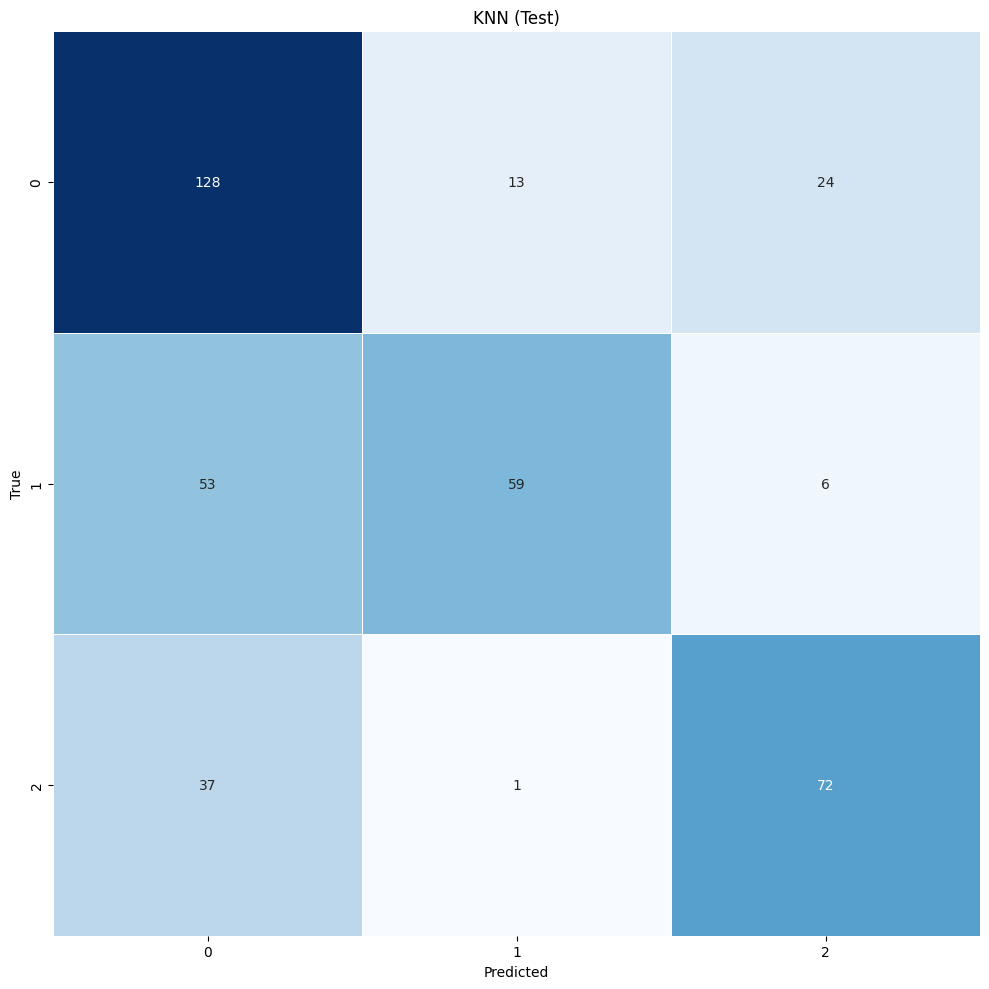

In [102]:
cm, labels = confusion_matrix(y_test, y_pred_test)
print_class(cm, labels)
plot_confusion_heatmap(cm, labels, "KNN (Test)", figsize=(10,10))
plt.show()

## **C. Model Visualization**

### 1. Heatmap Likelihood

Setiap kelas target punya ciri fitur berbeda, dan model Naive Bayes mempelajari pola ini untuk membuat klasifikasi prediksi.

(<Figure size 1000x400 with 2 Axes>,
 <Axes: title={'center': 'Feature Probabilities'}, xlabel='Features', ylabel='Classes'>)

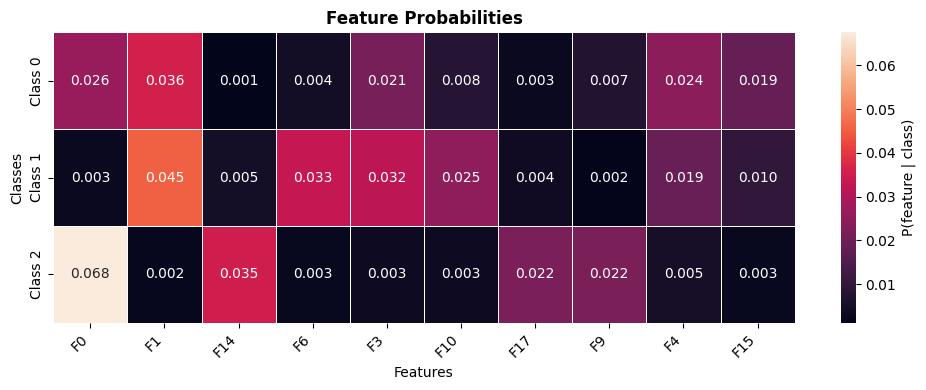

In [103]:
model.plot_likelihood_heatmap(top_k=10)

### 2. Prior vs Posterior

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Prior vs Posterior — Sample #0'}, xlabel='Class', ylabel='Probability'>)

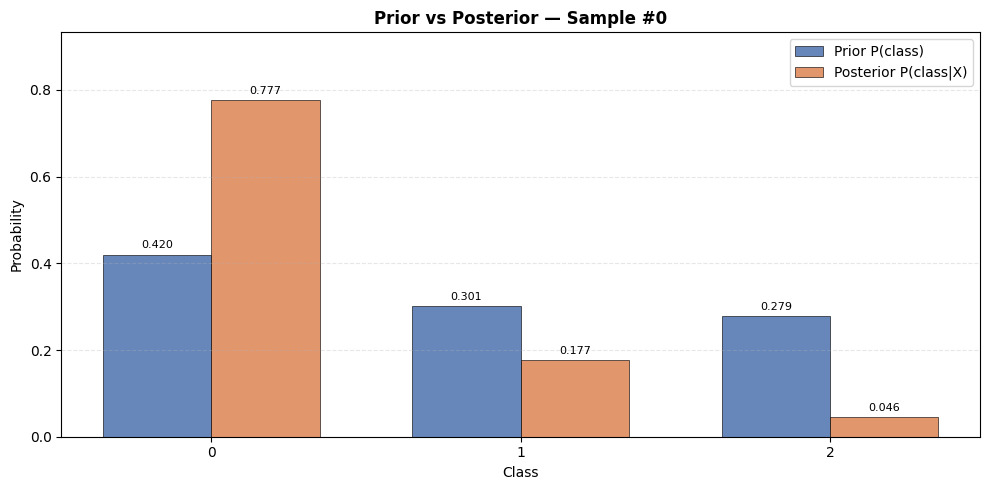

In [104]:
model.plot_prior_posterior(X_test_tfidf, sample_idx=0)

Jadi data sample dapat mengalahkan prior.

### 3. Class Separation

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Class Separation (Log-Likelihood)'}, xlabel='Log-Likelihood', ylabel='Frequency'>)

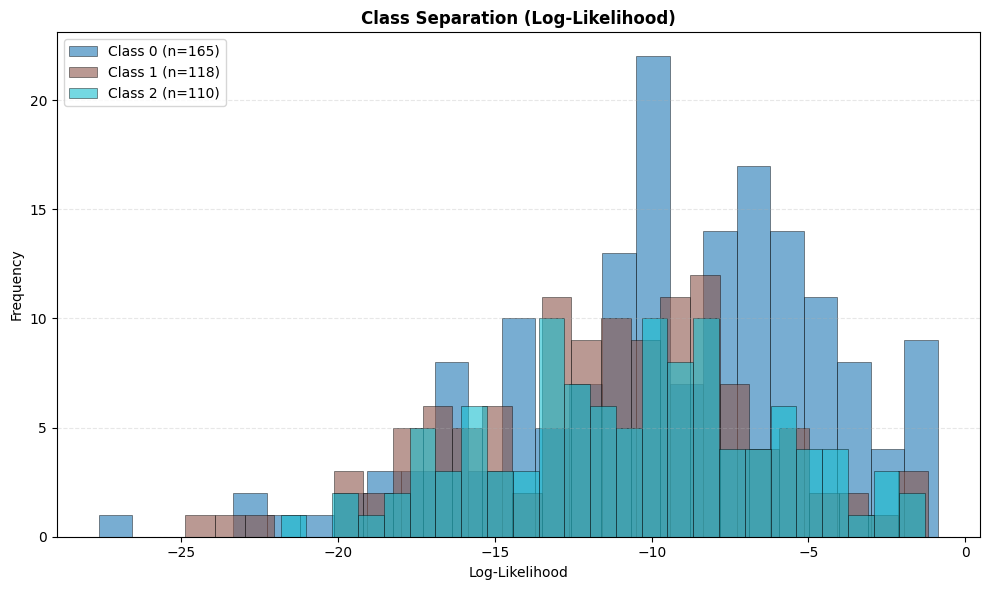

In [105]:
model.plot_class_separation(X_test_tfidf, y_test)

- Distribusi kelas agak tumpang tindih, tapi masih ada pergeseran
- Class 0 cenderung punya log-likelihood lebih tinggi
- Kalau histogram makin terpisah, model makin bagus. Dan ini masih overlap, kemungkinan benar masih banyak yang salah klasifikasi.
- Masih ada pola pemisahan antar kelas

# ***IV. Graphical User Interface*** | Modul D

In [106]:
from tkinter import messagebox, scrolledtext
class GUI:
    def __init__(self):
        self.root = tk.Tk()
        self.root.title("Hate Speech Detector")
        self.root.geometry("600x520")
        self.root.configure(bg='#1e1e2e')
        self.root.resizable(False, False)
        self.colors = {
            'bg': '#1e1e2e',
            'card': '#2a2a3e',
            'text': '#ffffff',
            'netral': '#27ae60',
            'agama': '#e74c3c',
            'ras': '#f39c12',
            'button': '#e94560'
        }
        self.setup()

    def setup(self):
        bg = self.colors['bg']
        card = self.colors['card']
        text = self.colors['text']

        header = tk.Frame(self.root, bg='#0f3460', height=70)
        header.pack(fill='x', padx=10, pady=10)
        header.pack_propagate(False)
        tk.Label(header, text="HATE SPEECH DETECTOR", font=("Arial", 16, "bold"), fg=text, bg='#0f3460').pack()
        
        input_frame = tk.Frame(self.root, bg=card, padx=15, pady=10)
        input_frame.pack(fill='x', padx=10, pady=5)
        tk.Label(input_frame, text="Masukkan kalimat", font=("Arial", 10, "bold"), fg=text, bg=card, anchor='w').pack(fill='x')
        self.input_text = scrolledtext.ScrolledText(input_frame, height=4, font=("Arial", 10), bg='#3a3a4e', fg=text, insertbackground=text, relief='flat')
        self.input_text.pack(fill='x', pady=8)

        btn_frame = tk.Frame(self.root, bg=bg)
        btn_frame.pack(pady=8)
        tk.Button(btn_frame, text="ANALISIS", font=("Arial", 10, "bold"), bg=self.colors['button'], fg='white', width=12, activebackground='#c73e54', command=self.analyze).pack(side='left', padx=5)
        tk.Button(btn_frame, text="HAPUS", font=("Arial", 10, "bold"), bg="#555555", fg='white', width=12, activebackground='#444444', command=self.clear).pack(side='left', padx=5)

        result_frame = tk.Frame(self.root, bg=card, padx=15, pady=10)
        result_frame.pack(fill='both', expand=True, padx=10, pady=5)
        tk.Label(result_frame, text='Hasil Analisis:', font=("Arial", 10, "bold"), fg=text, bg=card, anchor='w').pack(fill='x')
        self.result_label = tk.Label(result_frame, text="Masukkan kalimat", font=("Arial", 10, "bold"), fg="#888888", bg=card, wraplength=500)
        self.result_label.pack(pady=15)

        self.badge = tk.Label(result_frame, text="", font=("Arial", 10, "bold"), fg="white", padx=15, pady=5)
        
        self.prob_frame = tk.Frame(result_frame, bg=card)
        self.prob_frame.pack(fill='x', pady=10)

        tk.Label(self.root, text="Asta Production", font=("Arial", 8), fg="#555555", bg=bg).pack(pady=5)

    def preprocess(self, text):
        text = text_cleaning(text)
        tokens = text.split()
        tokens = normalize(tokens)
        tokens = remove(tokens)
        tokens = stem(tokens)
        return tokens

    def predict(self, text):
        tokens = self.preprocess(text)
        tfidf = vectorizer.trans([tokens])
        
        pred = model.predict(tfidf)[0]
        proba = model.predict_proba(tfidf)[0]
        
        return {
            'label': reverse[pred],
            'class': int(pred),
            'proba': {
                'Netral': float(proba[0]),
                'Agama': float(proba[1]),
                'Ras': float(proba[2])
            }
        }
    
    def analyze(self):
        text = self.input_text.get("1.0", tk.END).strip()

        if not text:
            messagebox.showwarning("Peringatan", "Masukkan kalimat")
            return

        result = self.predict(text)
        label = result['label']
        proba = result['proba']

        color_map = {
            'Netral': (self.colors['netral'], "Kalimat ini tidak mengandung hate speech"),
            'Agama': (self.colors['agama'], "Kalimat mengandung hate speech AGAMA"),
            'Ras': (self.colors['ras'], "Kalimat mengandung hate speech RAS/ETNIS")
        }
        
        color, msg = color_map[label]

        self.result_label.config(text=msg, fg=color)
        self.badge.config(text=label.upper(), bg=color)
        self.badge.pack(pady=5)

        for w in self.prob_frame.winfo_children():
            w.destroy()

        for cls, prob in proba.items():
            row = tk.Frame(self.prob_frame, bg=self.colors['card'])
            row.pack(fill='x', pady=2)
            tk.Label(row, text=f"{cls}:", width=8, font=("Arial", 9, "bold"), fg=self.colors['text'], bg=self.colors['card'], anchor='e').pack(side='left')

            bar_bg = tk.Frame(row, bg="#444444", height=16, width=320)
            bar_bg.pack(side='left', padx=8)
            bar_bg.pack_propagate(False)
            bar_color = {'Netral': self.colors['netral'], 
                         'Agama': self.colors['agama'], 
                         'Ras': self.colors['ras']}[cls]

            tk.Frame(bar_bg, bg=bar_color, height=16, width=int(320 * prob)).pack(side='left')
            tk.Label(row, text=f"{prob*100:.1f}%", font=("Arial", 9), fg=self.colors['text'], bg=self.colors['card'], width=7).pack(side='left')

    def clear(self):
        self.input_text.delete("1.0", tk.END)
        self.result_label.config(text="Masukkan kalimat", fg="#888888")
        self.badge.pack_forget()
        for w in self.prob_frame.winfo_children():
            w.destroy()

    def run(self):
        self.root.mainloop()

if __name__ == "__main__":
    app = GUI()
    app.run()

# ***V. Final Evaluation***

---
Copyright @ 2025. Asta Production. All rights reserved